# Reproduction Package for "MeerKAT radio observations of the neutron star low-mass X-ray binary Cen X-4 at low accretion rates" by Van den Eijnden et al. (2022). 

This Notebook reproduces all figures and analysis that requires python 2.7 due to dependencies in the linmix and aplpy codes. 

The below code will:
- re-create figures 1 and 2 to plot the MeerKAT field
- perform the linmix fits of $L_X$-$L_R$ relationship for Cen X-4, including all tests mentioned in the paper

# Step 0) Loading the basic input for the code

In [1]:
# Make sure to change this path to your local version, or otherwise comment out the noted line in the next cell
path = '/Library/Fonts/Arial Unicode.ttf'

In [2]:
# Loading of standard Python packages:
import numpy as np
import numpy.ma as ma

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as font_manager
import matplotlib.gridspec as gridspec
from matplotlib import colors
from matplotlib.patches import ConnectionPatch
from matplotlib.colors import LogNorm
import aplpy

from scipy import interpolate
from scipy import optimize
from scipy.integrate import quad
import scipy.special
import scipy.stats as ST

import os
from astropy import units as u
from astropy.units import cds
cds.enable()  

import linmix

from IPython.display import display, clear_output

# If the font should not be changed, comment out the next two lines:
prop = font_manager.FontProperties(fname=path)
mpl.rcParams['font.family'] = prop.get_name()
mpl.rcParams['pdf.fonttype']=42

params = {'text.usetex':False, 'mathtext.fontset':'custom', 'mathtext.default':'regular'}
mpl.rcParams.update(params)

# Basic plotting settings
single_col = 8.9 # cm
double_col = 18.3 # cm
def cm2inch(value):
    return value/2.54
FS  = 20
LS  = 20
MS  = 10
MEW = 3

%matplotlib inline

/opt/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


# Step 1) Plotting Figures 1 and 2: the images of the deep MeerKAT observation

Note that, while in the paper, we only show the field from the deepest MeerKAT observation, .fits images from the other three observations are also included in the reproduction package (in the MeerKAT_Fits_Images folder)

In [3]:
data = './MeerKAT_Fits_Images/CENX4_2020_09_26.fits'

### Figure 1: the full FOV

INFO: Setting slices=[0, 0] [aplpy.core]


/opt/anaconda3/envs/py27/lib/python2.7/site-packages/aplpy/labels.py:432: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if self.coord == x or self.axis.apl_tick_positions_world[ipos] > 0:
/opt/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/axes/_base.py:3152: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.5, right=-0.5
  'left=%s, right=%s') % (left, right))
/opt/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/axis.py:1086: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
/opt/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/axis.py:1096: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.wa

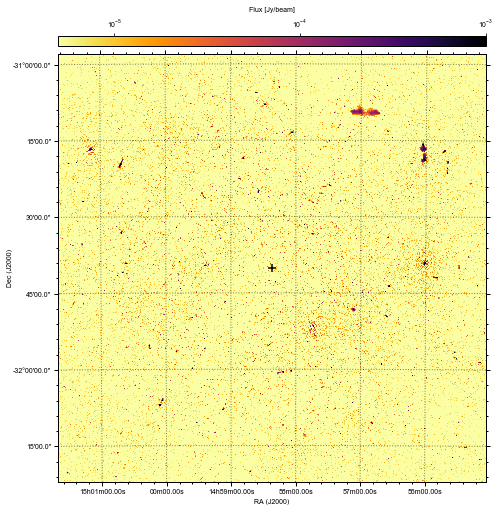

In [5]:
# Set the colormap
CM = 'inferno_r' # binary

# Define the image and the size:
fig = plt.figure(figsize=(cm2inch(double_col),cm2inch(double_col)))
plt.clf()

# Plot the map in the defined figure
cg = aplpy.FITSFigure(data, figure=fig, subplot=(1,1,1))
# Define the colormaps, min and max flux on the scale
cg.show_colorscale(cmap=CM,vmin=5e-6,vmax=1e-3, stretch='log')

# Define the best radio position: centre on this.
ra = 224.591395
dec = -31.668754
    
cg.recenter(ra, dec, radius=0.7)  # radius of 0.7 degrees.

# Mark a position, in this case a '+' for the SIMBAD position of the source
cg.show_markers(ra, dec, layer='marker_set_1', 
                edgecolor=None, facecolor='k', marker='+', s=50)

# Add the beam
cg.add_beam()
cg.beam.show()
cg.beam.set_major(5.755892 * u.arcsecond)
cg.beam.set_minor(5.755892 * u.arcsecond)
cg.beam.set_angle(0. * u.degree)
cg.beam.set_corner('bottom left')
cg.beam.set_linestyle('-')
cg.beam.set_edgecolor('k')
cg.beam.set_facecolor('w')
cg.beam.set_linewidth(1)

# Set the properties of the axis labels and ticks:
cg.axis_labels.set_xpad(4)
cg.axis_labels.set_ypad(0)
cg.axis_labels.set_font(size=7, weight='medium',
                         stretch='normal', family='arial',
                         style='normal', variant='normal')
cg.tick_labels.set_font(size=7, weight='medium',
                         stretch='normal', family='arial',
                         style='normal', variant='normal')
cg.ticks.set_length(4)
cg.ticks.set_linewidth(1)
cg.ticks.set_color('black')

cg.frame.set_linewidth(1)  # points
cg.frame.set_color('black')

# Define the properties of the grid
cg.add_grid()
cg.grid.show()
cg.grid.set_color('k')
cg.grid.set_linestyle(':')
cg.grid.set_linewidth(1)

# Hacked code to include the colorbar: 
# the colorbar never comes out beautifully for me in the default settings, so the code below
# defines an empty data set and plots it with imshow on a new axis, with the same colormap and min/max flux.
ax = fig.add_subplot(111)
fakedata = np.asarray([[],[]])
plt.imshow(fakedata,aspect='auto',origin='lower',vmin=5.0e-6,vmax=1e-3,cmap=CM,rasterized=True, norm=LogNorm(vmin=5.0e-6, vmax=1.0e-3))

# Then, I make a colorbar, and set all its properties; 
cb = plt.colorbar(orientation='horizontal', cmap=CM, shrink=1, aspect=40, pad=0, 
                  fraction=1.0,drawedges=True)

cb.set_label(r'Flux [Jy/beam]', fontsize=7, fontweight='medium', family='arial', labelpad=5)
cb.set_ticks([1e-5, 1e-4, 1e-3], update_ticks=True)
cb.set_ticklabels([r'$10^{-5}$', r'$10^{-4}$', r'$10^{-3}$'])
cb.ax.xaxis.set_tick_params(pad=2)
cb.ax.tick_params(labelsize=7) 
cb.outline.set_linewidth(1)
cb.dividers.set_color('none')

# Make sure the color bar has ticks and labels at the top, since the bar is on the top as well. 
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

for l in cb.ax.xaxis.get_ticklabels():
    l.set_family("arial")
    
# Remove the axis for the 'fake' plot, that is only there for the colorbar.
ax.axis('off')

plt.tight_layout()
plt.savefig('./Figure1_2/Figure1.png', dpi=1000)

### Figure 2: the zoom of the source position

INFO: Setting slices=[0, 0] [aplpy.core]


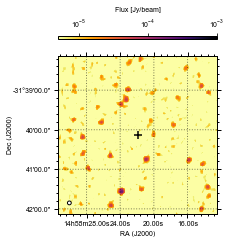

In [6]:
# Set the colormap
CM = 'inferno_r' # binary

# Define the image and the size:
fig = plt.figure(figsize=(cm2inch(single_col),cm2inch(single_col)))
plt.clf()

# Plot the map in the defined figure
cg = aplpy.FITSFigure(data, figure=fig, subplot=(1,1,1))
# Define the colormaps, min and max flux on the scale
cg.show_colorscale(cmap=CM,vmin=5e-6,vmax=1e-3, stretch='log')

# Define the best radio position: centre on this. Remove this (including cg.recenter) to plot the entire field.
ra = 224.591395
dec = -31.668754
    
cg.recenter(ra, dec, radius=0.1/3.)  # See the much smaller radius for this image.

# Mark a position, in this case a '+' for the SIMBAD position of the source
cg.show_markers(ra, dec, layer='marker_set_1', 
                edgecolor=None, facecolor='k', marker='+', s=50)

# Add the beam
cg.add_beam()
cg.beam.show()
cg.beam.set_major(5.755892 * u.arcsecond)
cg.beam.set_minor(5.755892 * u.arcsecond)
cg.beam.set_angle(0. * u.degree)
cg.beam.set_corner('bottom left')
cg.beam.set_linestyle('-')
cg.beam.set_edgecolor('k')
cg.beam.set_facecolor('w')
cg.beam.set_linewidth(1)

# Set the properties of the axis labels and ticks:
cg.axis_labels.set_xpad(4)
cg.axis_labels.set_ypad(0)
cg.axis_labels.set_font(size=7, weight='medium',
                         stretch='normal', family='arial',
                         style='normal', variant='normal')
cg.tick_labels.set_font(size=7, weight='medium',
                         stretch='normal', family='arial',
                         style='normal', variant='normal')
cg.ticks.set_length(4)
cg.ticks.set_linewidth(1)
cg.ticks.set_color('black')

cg.frame.set_linewidth(1)  # points
cg.frame.set_color('black')

# Define the properties of the grid
cg.add_grid()
cg.grid.show()
cg.grid.set_color('k')
cg.grid.set_linestyle(':')
cg.grid.set_linewidth(1)

# Same code to include a colorbar (see above)
ax = fig.add_subplot(111)
fakedata = np.asarray([[],[]])
plt.imshow(fakedata,aspect='auto',origin='lower',vmin=5.0e-6,vmax=1e-3,cmap=CM,rasterized=True, norm=LogNorm(vmin=5.0e-6, vmax=1.0e-3))

cb = plt.colorbar(orientation='horizontal', cmap=CM, shrink=1, aspect=40, pad=0, 
                  fraction=1.0,drawedges=True)

cb.set_label(r'Flux [Jy/beam]', fontsize=7, fontweight='medium', family='arial', labelpad=5)
cb.set_ticks([1e-5, 1e-4, 1e-3], update_ticks=True)
cb.set_ticklabels([r'$10^{-5}$', r'$10^{-4}$', r'$10^{-3}$'])
cb.ax.xaxis.set_tick_params(pad=2)
cb.ax.tick_params(labelsize=7) 
cb.outline.set_linewidth(1)
cb.dividers.set_color('none')

cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

for l in cb.ax.xaxis.get_ticklabels():
    l.set_family("arial")
    
# Remove the axis for the 'fake' plot, that is only there for the colorbar.
ax.axis('off')

plt.tight_layout()
plt.savefig('./Figure1_2/Figure2.png', dpi=1000)

# Step 2) performing the $L_X - L_R$ analysis

## 2a) setup and definition of the data:

In [4]:
# The anchors in X-ray and radio luminosity
lx0 = 2.00e36
lr0 = 3.72e28

In [5]:
# The assumed distance to the source:
D_CenX4 = 1.2
dD_CenX4 = 0.3

In [7]:
# The data: Lx and Lr, with errors, and then converted to log scale:
# Order: 
# [0] == Tudor et al. 2017 deep limit
# [1:5] == the new data from Van den Eijnden et al. 2022
# [5:] == the archival radio detections as presented in Tudor et al. 2017
lx = np.asarray([1.458e+31, 6.0e31, 1.3e33, 5.5e32, 3.5e32, 7.64e+36, 5.52e+36, 2.76e+36, 3.46e+36, 1.08e+36, 1.08e+36])
dlx = np.asarray([9.e+30, 1.7e31, 0.3e33, 0.4e32, 0.9e32, 6.38e+35, 4.55e+35, 5.23e+35, 5.92e+35, 3.69e+35, 3.69e+35])
lr = np.asarray([1.21e+26, 1.1e26, 5.9e26, 4.7e26, 4.1e26, 2.94e+28, 4.84e+28, 6.91e+28, 6.13e+28, 4.32e+28, 1.73e+28])
dlr = np.asarray([0.333*1.21e+26, 0.333*1.1e26, 0.333*5.9e26, 0.333*4.7e26, 0.333*4.1e26, 1.38e+28, 1.38e+28, 2.16e+28, 2.85e+28, 2.16e+28, 8.64e+27])

# 0 == radio non-detection, 1 == radio detection
delta = np.asarray([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1])

lx_scaled = lx/lx0
dlx_scaled_p = (lx+dlx)/lx0
dlx_scaled_m = (lx-dlx)/lx0

log_lx_scaled = np.log10(lx_scaled)
log_dlx_scaled_p = np.log10(dlx_scaled_p)
log_dlx_scaled_m = np.log10(dlx_scaled_m)
log_dlx_scaled = (log_dlx_scaled_p - log_dlx_scaled_m)/2.

lr_scaled = lr/lr0
dlr_scaled_p = (lr+dlr)/lr0
dlr_scaled_m = (lr-dlr)/lr0

log_lr_scaled = np.log10(lr_scaled)
log_dlr_scaled_p = np.log10(dlr_scaled_p)
log_dlr_scaled_m = np.log10(dlr_scaled_m)
log_dlr_scaled = (log_dlr_scaled_p - log_dlr_scaled_m)/2.

In [8]:
# Defining a function that can plot histograms using the output of np.histogram and a defined axis:

def hist_plotter(ax, edges, counts, C='k', LW=2, normalized_to_one=True, label='', ALPHA=1.0):
    
    if normalized_to_one:
        counts = counts/float(max(counts))
    
    ax.plot([edges[0]]*2, [0, counts[0]], lw=LW, color=C, label=label, alpha=ALPHA)
    ax.plot([edges[-1]]*2, [counts[-1], 0], lw=LW, color=C, alpha=ALPHA)
    for i in xrange(len(edges)-1):
        ax.plot([edges[i], edges[i+1]], [counts[i]]*2, lw=LW, color=C, alpha=ALPHA)
        if i != 0:
            ax.plot([edges[i]]*2, [counts[i-1],counts[i]], lw=LW, color=C, alpha=ALPHA)
            
    return

## 2b) A first test fit to all data for D = 1.2 kpc 
Here, we test the use of linmix using all data and assuming the 1.2 kpc distance (which was used to calculate the luminosities in the lx, dlx, lr, and dlr arrays). This should take a couple of seconds to run on a modern laptop. If it takes significantly longer, later parts of this code may better be executed on another machine or by using the pre-calculated data files (setting the perform_full_analysis bool to False)

In [9]:
lm = linmix.LinMix(x=log_lx_scaled, y=log_lr_scaled, xsig=log_dlx_scaled, ysig=log_dlr_scaled, delta=delta,K=3)
lm.run_mcmc(miniter=5000,maxiter=5000,silent=True)

In [10]:
# Extract the fitted parameters for Alpha* (== Xi in the paper), Beta, and Sigma
# * Here, we use alpha to stick to the nomenclature of the linmix documentation

alphas = []
betas = []
sigmas = []
for i in xrange(len(lm.chain)):
    alphas.append(lm.chain[i]['alpha'])
    betas.append(lm.chain[i]['beta'])
    sigmas.append(lm.chain[i]['sigsqr'])
    
# Calculating the percentiles:
alpha_16 = np.percentile(alphas,16)
alpha_50 = np.percentile(alphas,50)
alpha_84 = np.percentile(alphas,84)
alpha_mean = np.mean(alphas)

beta_10 = np.percentile(betas,10)
beta_16 = np.percentile(betas,16)
beta_50 = np.percentile(betas,50)
beta_84 = np.percentile(betas,84)
beta_mean = np.mean(betas)
    
# Creating histograms:    
alpha_counts, alpha_edges = np.histogram(alphas, bins=100, density=True)
beta_counts, beta_edges = np.histogram(betas, bins=100, density=True)
sigma_counts, sigma_edges = np.histogram(sigmas, bins=500, range=[0,2], density=True)

# Printing the percentiles for offset and slope
print(alpha_50, alpha_50-alpha_16, alpha_84-alpha_50)
print(beta_50, beta_50-beta_16, beta_84-beta_50)
print(beta_10)

(-0.17052106858696925, 0.2751146153048363, 0.2217757800361071)
(1.2032624007748511, 0.43709321389089717, 0.468599355207888)
0.7049768482853551


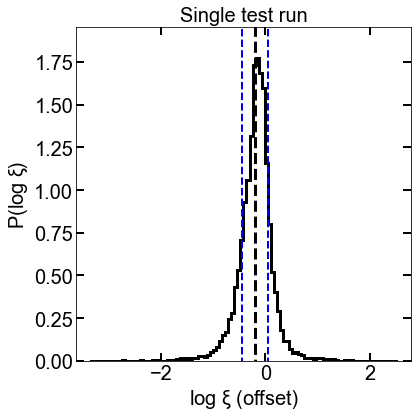

In [12]:
# Plotting the outcome of this single run for beta:

###############################################################################################################
### Setting up the figure:   
###############################################################################################################
fig = plt.figure(figsize=(cm2inch(15.),cm2inch(15)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=3)
ax.tick_params(labelsize=LS, length=4, width=1, axis='both', which='minor', pad=3)
    
ax.set_ylim(0, 1.1*max(alpha_counts))

ax.set_xlabel(r'log $\xi$ (offset)', fontsize=FS)
ax.set_ylabel(r'P(log $\xi$)', fontsize=FS)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

###############################################################################################################
### Plotting histograms
###############################################################################################################

hist_plotter(ax=ax, edges=alpha_edges, counts=alpha_counts, LW=3, normalized_to_one=False)

ax.plot([alpha_16,alpha_16], [-1,1000], 'b--', lw=2)
ax.plot([alpha_84,alpha_84], [-1,1000], 'b--', lw=2)
ax.plot([alpha_mean,alpha_mean], [-1,1000], 'k--', lw=3)

ax.set_title('Single test run', fontsize=FS)

###############################################################################################################
plt.tight_layout()
plt.show()

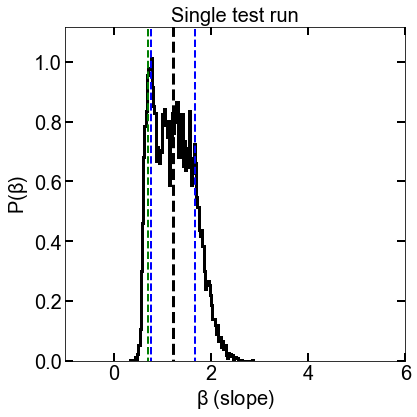

In [13]:
# Plotting the outcome of this single test run for beta:

###############################################################################################################
### Setting up the figure:   
###############################################################################################################
fig = plt.figure(figsize=(cm2inch(15.),cm2inch(15)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=3)
ax.tick_params(labelsize=LS, length=4, width=1, axis='both', which='minor', pad=3)
    
ax.set_ylim(0, 1.1*max(beta_counts))
ax.set_xlim(-1,6)

ax.set_xlabel(r'$\beta$ (slope)', fontsize=FS)
ax.set_ylabel(r'$P(\beta)$', fontsize=FS)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

###############################################################################################################
### Plotting histograms
###############################################################################################################

hist_plotter(ax=ax, edges=beta_edges, counts=beta_counts, LW=3, normalized_to_one=False)

ax.plot([beta_16,beta_16], [-1,1000], 'b--', lw=2)
ax.plot([beta_84,beta_84], [-1,1000], 'b--', lw=2)
ax.plot([beta_10,beta_10], [-1,1000], 'g--', lw=2)
ax.plot([beta_mean,beta_mean], [-1,1000], 'k--', lw=3)

ax.set_title('Single test run', fontsize=FS)

###############################################################################################################
plt.tight_layout()
plt.show()

## 2c) the full fit: 100 runs with varying distance
For the full fit, we repeat the linmix fit 100 times, each time varying the distance in a Gaussian around the mean value. Thereby, we fold in the uncertainty on the distance into those on the fitted parameters.

Note that you can opt to run the full analysis, or instead read in pre-calculated output files to save time / reproduce the version reported in the paper.

In [26]:
perform_full_analysis = False

In [27]:
N_runs = 100

In [28]:
if not perform_full_analysis:
    all_alphas = np.loadtxt('./MCMC_parfiles/all_alphas.txt')
    all_betas = np.loadtxt('./MCMC_parfiles/all_betas.txt')
    all_sigmas = np.loadtxt('./MCMC_parfiles/all_sigmas.txt')
    
    alpha_16 = np.loadtxt('./MCMC_parfiles/alpha_16.txt')
    alpha_84 = np.loadtxt('./MCMC_parfiles/alpha_84.txt')
    alpha_50 = np.loadtxt('./MCMC_parfiles/alpha_50.txt')
    alpha_mean = np.loadtxt('./MCMC_parfiles/alpha_mean.txt')
    
    beta_10 = np.loadtxt('./MCMC_parfiles/beta_10.txt')
    beta_16 = np.loadtxt('./MCMC_parfiles/beta_16.txt')
    beta_84 = np.loadtxt('./MCMC_parfiles/beta_84.txt')
    beta_50 = np.loadtxt('./MCMC_parfiles/beta_50.txt')
    beta_mean = np.loadtxt('./MCMC_parfiles/beta_mean.txt')
    
    sigma_16 = np.loadtxt('./MCMC_parfiles/sigma_16.txt')
    sigma_84 = np.loadtxt('./MCMC_parfiles/sigma_84.txt')
    sigma_50 = np.loadtxt('./MCMC_parfiles/sigma_50.txt')
    sigma_mean = np.loadtxt('./MCMC_parfiles/sigma_mean.txt')

In [29]:
if perform_full_analysis:
    all_alphas = []
    all_betas = []
    all_sigmas = []
    
    alpha_16 = []
    alpha_50 = []
    alpha_84 = []
    alpha_mean = []

    beta_10 = []
    beta_16 = []
    beta_50 = []
    beta_84 = []
    beta_mean = []

    sigma_16 = []
    sigma_50 = []
    sigma_84 = []
    sigma_mean = []
    
    for j in range(N_runs):
        clear_output(wait=True)
        display('Iteration '+str(j+1)+' Percentage: '+str((float(j+1)/N_runs)*100.0)+'%')
        
        # Apply a correction on the luminosities due to distance, in log space:
        X_CenX4 = np.random.normal(loc=D_CenX4, scale=dD_CenX4, size=1)[0]/D_CenX4
        X_array = np.asarray([X_CenX4]*11)
        d_corr = 2.*np.log10(X_array)
        
        # Run the MCMC
        lm = linmix.LinMix(x=log_lx_scaled+d_corr, y=log_lr_scaled+d_corr, xsig=log_dlx_scaled, ysig=log_dlr_scaled, delta=delta, K=3)
        lm.run_mcmc(miniter=5000,maxiter=5000,silent=True)
        
        # Extract the fitted parameters
        alphas = []
        betas = []
        sigmas = []
        for i in xrange(len(lm.chain)):
            alphas.append(lm.chain[i]['alpha'])
            betas.append(lm.chain[i]['beta'])
            sigmas.append(lm.chain[i]['sigsqr'])
        all_alphas = all_alphas + alphas
        all_betas = all_betas + betas
        all_sigmas = all_sigmas + sigmas

        # Calculating the percentiles, modes, and means:
        alpha_16.append(np.percentile(alphas,16))
        alpha_50.append(np.percentile(alphas,50))
        alpha_84.append(np.percentile(alphas,84))
        alpha_mean.append(np.mean(alphas))

        beta_10.append(np.percentile(betas,10))
        beta_16.append(np.percentile(betas,16))
        beta_50.append(np.percentile(betas,50))
        beta_84.append(np.percentile(betas,84))
        beta_mean.append(np.mean(betas))

        sigma_16.append(np.percentile(sigmas,16))
        sigma_50.append(np.percentile(sigmas,50))
        sigma_84.append(np.percentile(sigmas,84))
        sigma_mean.append(np.mean(sigmas))

        # Create histograms
        alpha_counts, alpha_edges = np.histogram(alphas, bins=200, density=True)
        beta_counts, beta_edges = np.histogram(betas, bins=200, density=True)
        sigma_counts, sigma_edges = np.histogram(sigmas, bins=500, range=[0,2], density=True)
        
    # Save the raw output:
    np.savetxt('./MCMC_parfiles/all_alphas.txt', all_alphas)
    np.savetxt('./MCMC_parfiles/all_betas.txt', all_betas)
    np.savetxt('./MCMC_parfiles/all_sigmas.txt', all_sigmas)
    
    np.savetxt('./MCMC_parfiles/alpha_16.txt', alpha_16)
    np.savetxt('./MCMC_parfiles/alpha_84.txt', alpha_84)
    np.savetxt('./MCMC_parfiles/alpha_50.txt', alpha_50)
    np.savetxt('./MCMC_parfiles/alpha_mean.txt', alpha_mean)
    
    np.savetxt('./MCMC_parfiles/beta_10.txt', beta_10)
    np.savetxt('./MCMC_parfiles/beta_16.txt', beta_16)
    np.savetxt('./MCMC_parfiles/beta_84.txt', beta_84)
    np.savetxt('./MCMC_parfiles/beta_50.txt', beta_50)
    np.savetxt('./MCMC_parfiles/beta_mean.txt', beta_mean)
    
    np.savetxt('./MCMC_parfiles/sigma_16.txt', sigma_16)
    np.savetxt('./MCMC_parfiles/sigma_84.txt', sigma_84)
    np.savetxt('./MCMC_parfiles/sigma_50.txt', sigma_50)
    np.savetxt('./MCMC_parfiles/sigma_mean.txt', sigma_mean)

We stress that the below output values are not yes the ones reported in the paper, as the ones below are calculated from combining the output from ALL runs. In the paper, we follow Gusinskaia et al. 2020 and instead use the mean values of the median, 16th, and 84th percentile calculated from each individual run. Those values are calculated later on, but we include the following cell for completeness. 

In [32]:
print "The fitted values and uncertainies based on the mean, 16th, and 84th percentile of all values"
print "----------------------------------------------------------------------------------------------"
print 'Alpha =', np.round(np.mean(all_alphas),3), ', -'+str(np.round(np.mean(all_alphas)-np.percentile(all_alphas,16),3)), '+'+str(np.round(np.percentile(all_alphas,84)-np.mean(all_alphas),3))
print 'Beta =', np.round(np.mean(all_betas),3), ', -'+str(np.round(np.mean(all_betas)-np.percentile(all_betas,16),3)), '+'+str(np.round(np.percentile(all_betas,84)-np.mean(all_betas),3))
print 'Sigma =', np.round(np.mean(all_sigmas),3), ', -'+str(np.round(np.mean(all_sigmas)-np.percentile(all_sigmas,16),3)), '+'+str(np.round(np.percentile(all_sigmas,84)-np.mean(all_sigmas),3))
print ''
print "The fitted values and uncertainties based on the median, 16th, and 84th percentile of all values"
print "----------------------------------------------------------------------------------------------"
print 'Alpha =', np.round(np.percentile(all_alphas,50),3), ', -'+str(np.round(np.percentile(all_alphas,50)-np.percentile(all_alphas,16),3)), '+'+str(np.round(np.percentile(all_alphas,84)-np.percentile(all_alphas,50),3))
print 'Beta =', np.round(np.percentile(all_betas,50),3), ', -'+str(np.round(np.percentile(all_betas,50)-np.percentile(all_betas,16),3)), '+'+str(np.round(np.percentile(all_betas,84)-np.percentile(all_betas,50),3))
print 'Sigma =', np.round(np.percentile(all_sigmas,50),3), ', -'+str(np.round(np.percentile(all_sigmas,50)-np.percentile(all_sigmas,16),3)), '+'+str(np.round(np.percentile(all_sigmas,84)-np.percentile(all_sigmas,50),3))
print ''
print "The 90% lower limit on beta from all values"
print "-----------------------------------------------------------"
print "Beta > ", np.round(np.percentile(all_betas,10),3)




The fitted values and uncertainies based on the mean, 16th, and 84th percentile of all values
----------------------------------------------------------------------------------------------
Alpha = -0.16 , -0.235 +0.237
Beta = 1.104 , -0.407 +0.41
Sigma = 0.532 , -0.48 +0.23

The fitted values and uncertainties based on the median, 16th, and 84th percentile of all values
----------------------------------------------------------------------------------------------
Alpha = -0.139 , -0.256 +0.215
Beta = 0.953 , -0.257 +0.561
Sigma = 0.196 , -0.143 +0.567

The 90% lower limit on beta from all values
-----------------------------------------------------------
Beta >  0.653


We also plot a comparison between one single run of linmix and the combined output of all linmix runs: this will highlight if there is a systematic bias introduced by the assumed distance in a single run.

In [30]:
# Defining a histogram of all alpha and beta values from all runs:
all_alpha_counts, all_alpha_edges = np.histogram(all_alphas, bins=1000, density=True)
all_beta_counts, all_beta_edges = np.histogram(all_betas, bins=1000, density=True)

# Also loading data for the last of the 100 runs for comparison:
onerun_alpha_counts, onerun_alpha_edges = np.histogram(alphas, bins=100, density=True)
onerun_beta_counts, onerun_beta_edges = np.histogram(betas, bins=100, density=True)

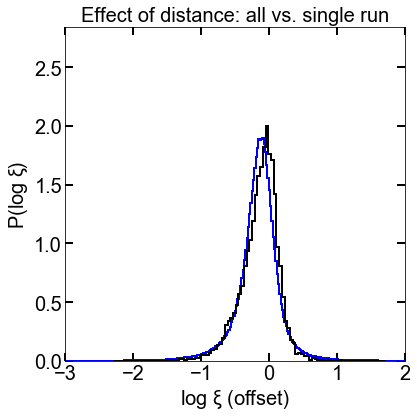

In [31]:
###############################################################################################################
### Setting up the figure:   
###############################################################################################################
fig = plt.figure(figsize=(cm2inch(15.),cm2inch(15)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=3)
ax.tick_params(labelsize=LS, length=4, width=1, axis='both', which='minor', pad=3)
    
ax.set_ylim(0, 1.5*max(all_alpha_counts))
ax.set_xlim(-3,2)

ax.set_xlabel(r'log $\xi$ (offset)', fontsize=FS)
ax.set_ylabel(r'P(log $\xi$)', fontsize=FS)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

###############################################################################################################
### Plotting histograms
###############################################################################################################

hist_plotter(ax=ax, edges=all_alpha_edges, counts=all_alpha_counts, LW=2, normalized_to_one=False, C='b')
hist_plotter(ax=ax, edges=onerun_alpha_edges, counts=onerun_alpha_counts, LW=2, normalized_to_one=False, C='k')

ax.set_title(r'Effect of distance: all vs. single run', fontsize=FS)

###############################################################################################################
plt.tight_layout()
plt.show()

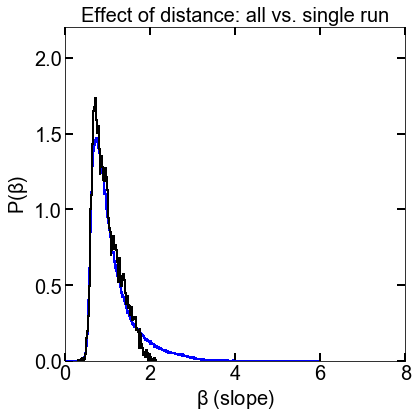

In [32]:
###############################################################################################################
### Setting up the figure:   
###############################################################################################################
fig = plt.figure(figsize=(cm2inch(15.),cm2inch(15)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=3)
ax.tick_params(labelsize=LS, length=4, width=1, axis='both', which='minor', pad=3)
    
ax.set_ylim(0, 1.5*max(all_beta_counts))
ax.set_xlim(0, 8)

ax.set_xlabel(r'$\beta$ (slope)', fontsize=FS)
ax.set_ylabel(r'$P(\beta)$', fontsize=FS)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

###############################################################################################################
### Plotting histograms
###############################################################################################################

hist_plotter(ax=ax, edges=all_beta_edges, counts=all_beta_counts, LW=2, normalized_to_one=False, C='b')
hist_plotter(ax=ax, edges=onerun_beta_edges, counts=onerun_beta_counts, LW=2, normalized_to_one=False, C='k')

ax.set_title(r'Effect of distance: all vs. single run', fontsize=FS)

###############################################################################################################
plt.tight_layout()
plt.show()

From these comparisons, we conclude that, while there is a clear effect of including more runs in terms of the smoothness of the distributions, we do not observe a systematic bias in the measured parameters.

## 2d) Determining the fitted parameters following Gusinskaia et al. (2020)

As mentioned earlier, for the reported parameters in the paper, we calculate the mean values of the median, 16th percentile and 84th percentile of the parameter, calculated from each of the runs. 

In [33]:
print "The fitted values based on the mean of the median, 16th, and 84th percentile of the 100 runs"
print "--------------------------------------------------------------------------------------------"
print 'Alpha =', np.round(np.mean(alpha_50),3), '+'+str(np.round(np.mean(alpha_84)-np.mean(alpha_50),3)), str(np.round(np.mean(alpha_16)-np.mean(alpha_50),3))
print 'Beta =', np.round(np.mean(beta_50),3), '+'+str(np.round(np.mean(beta_84)-np.mean(beta_50),3)), str(np.round(np.mean(beta_16)-np.mean(beta_50),3))

The fitted values based on the mean of the median, 16th, and 84th percentile of the 100 runs
--------------------------------------------------------------------------------------------
Alpha = -0.141 +0.224 -0.268
Beta = 0.984 +0.595 -0.276


We also use the same approach to report the lower limit on the slope $\beta$ at the 90% confidence level:

In [34]:
print 'Beta >', np.round(np.mean(beta_10),2), 'at 90% confidence level'

Beta > 0.66 at 90% confidence level


## 2e) Repeating all steps above for the archival data (e.g. Tudor et al. 2017)
To assess the effect of the MeerKAT data, we re-perform these fits using only data from Tudor et al. 2017. Note that we jump straight into the full analysis with 100 repeats of the linmix fits. 

Note that we don't show the same histograms here as we do above; however, that code is straightforward to copy and include, in order to show those histograms here as well. Importantly, when we do plot those histograms, we find that the distance variations have a similar effect here.

In [35]:
lx = np.asarray([1.458e+31, 7.64e+36, 5.52e+36, 2.76e+36, 3.46e+36, 1.08e+36, 1.08e+36])
dlx = np.asarray([9.e+30, 6.38e+35, 4.55e+35, 5.23e+35, 5.92e+35, 3.69e+35, 3.69e+35])
lr = np.asarray([1.21e+26, 2.94e+28, 4.84e+28, 6.91e+28, 6.13e+28, 4.32e+28, 1.73e+28])
dlr = np.asarray([0.333*1.21e+26, 1.38e+28, 1.38e+28, 2.16e+28, 2.85e+28, 2.16e+28, 8.64e+27])

delta = np.asarray([0, 1, 1, 1, 1, 1, 1])

lx_scaled = lx/lx0
dlx_scaled_p = (lx+dlx)/lx0
dlx_scaled_m = (lx-dlx)/lx0

log_lx_scaled = np.log10(lx_scaled)
log_dlx_scaled_p = np.log10(dlx_scaled_p)
log_dlx_scaled_m = np.log10(dlx_scaled_m)
log_dlx_scaled = (log_dlx_scaled_p - log_dlx_scaled_m)/2.

lr_scaled = lr/lr0
dlr_scaled_p = (lr+dlr)/lr0
dlr_scaled_m = (lr-dlr)/lr0

log_lr_scaled = np.log10(lr_scaled)
log_dlr_scaled_p = np.log10(dlr_scaled_p)
log_dlr_scaled_m = np.log10(dlr_scaled_m)
log_dlr_scaled = (log_dlr_scaled_p - log_dlr_scaled_m)/2.

In [36]:
perform_full_analysis = False

In [37]:
N_runs = 100

In [38]:
if not perform_full_analysis:
    all_alphaOLDs = np.loadtxt('./MCMC_parfiles_Archival/all_alphaOLDs.txt')
    all_betaOLDs = np.loadtxt('./MCMC_parfiles_Archival/all_betaOLDs.txt')
    all_sigmaOLDs = np.loadtxt('./MCMC_parfiles_Archival/all_sigmaOLDs.txt')
    
    alphaOLD_16 = np.loadtxt('./MCMC_parfiles_Archival/alphaOLD_16.txt')
    alphaOLD_84 = np.loadtxt('./MCMC_parfiles_Archival/alphaOLD_84.txt')
    alphaOLD_50 = np.loadtxt('./MCMC_parfiles_Archival/alphaOLD_50.txt')
    alphaOLD_mean = np.loadtxt('./MCMC_parfiles_Archival/alphaOLD_mean.txt')
    
    betaOLD_10 = np.loadtxt('./MCMC_parfiles_Archival/betaOLD_10.txt')
    betaOLD_16 = np.loadtxt('./MCMC_parfiles_Archival/betaOLD_16.txt')
    betaOLD_84 = np.loadtxt('./MCMC_parfiles_Archival/betaOLD_84.txt')
    betaOLD_50 = np.loadtxt('./MCMC_parfiles_Archival/betaOLD_50.txt')
    betaOLD_mean = np.loadtxt('./MCMC_parfiles_Archival/betaOLD_mean.txt')
    
    sigmaOLD_16 = np.loadtxt('./MCMC_parfiles_Archival/sigmaOLD_16.txt')
    sigmaOLD_84 = np.loadtxt('./MCMC_parfiles_Archival/sigmaOLD_84.txt')
    sigmaOLD_50 = np.loadtxt('./MCMC_parfiles_Archival/sigmaOLD_50.txt')
    sigmaOLD_mean = np.loadtxt('./MCMC_parfiles_Archival/sigmaOLD_mean.txt')

In [39]:
if perform_full_analysis:
    all_alphaOLDs = []
    all_betaOLDs = []
    all_sigmaOLDs = []
    
    alphaOLD_16 = []
    alphaOLD_50 = []
    alphaOLD_84 = []
    alphaOLD_mean = []

    betaOLD_10 = []
    betaOLD_16 = []
    betaOLD_50 = []
    betaOLD_84 = []
    betaOLD_mean = []

    sigmaOLD_16 = []
    sigmaOLD_50 = []
    sigmaOLD_84 = []
    sigmaOLD_mean = []

    for j in range(N_runs):
        clear_output(wait=True)
        display('Iteration '+str(j+1)+' Percentage: '+str((float(j+1)/N_runs)*100.0)+'%')
        
        X_CenX4 = np.random.normal(loc=D_CenX4, scale=dD_CenX4, size=1)[0]/D_CenX4
        X_array = np.asarray([X_CenX4]*7)
        d_corr = 2.*np.log10(X_array)
        
        # Run the MCMC
        lm = linmix.LinMix(x=log_lx_scaled+d_corr, y=log_lr_scaled+d_corr, xsig=log_dlx_scaled, ysig=log_dlr_scaled, delta=delta, K=3)
        lm.run_mcmc(miniter=5000,maxiter=5000,silent=True)
        
        # Extract the fitted parameters
        alphaOLDs = []
        betaOLDs = []
        sigmaOLDs = []
        for i in xrange(len(lm.chain)):
            alphaOLDs.append(lm.chain[i]['alpha'])
            betaOLDs.append(lm.chain[i]['beta'])
            sigmaOLDs.append(lm.chain[i]['sigsqr'])
        all_alphaOLDs = all_alphaOLDs + alphaOLDs
        all_betaOLDs = all_betaOLDs + betaOLDs
        all_sigmaOLDs = all_sigmaOLDs + sigmaOLDs

        # Calculating the percentiles, modes, and means:
        alphaOLD_16.append(np.percentile(alphaOLDs,16))
        alphaOLD_50.append(np.percentile(alphaOLDs,50))
        alphaOLD_84.append(np.percentile(alphaOLDs,84))
        alphaOLD_mean.append(np.mean(alphaOLDs))

        betaOLD_10.append(np.percentile(betaOLDs,10))
        betaOLD_16.append(np.percentile(betaOLDs,16))
        betaOLD_50.append(np.percentile(betaOLDs,50))
        betaOLD_84.append(np.percentile(betaOLDs,84))
        betaOLD_mean.append(np.mean(betaOLDs))

        sigmaOLD_16.append(np.percentile(sigmaOLDs,16))
        sigmaOLD_50.append(np.percentile(sigmaOLDs,50))
        sigmaOLD_84.append(np.percentile(sigmaOLDs,84))
        sigmaOLD_mean.append(np.mean(sigmaOLDs))

        # Create histograms
        alphaOLD_counts, alphaOLD_edges = np.histogram(alphaOLDs, bins=200, density=True)
        betaOLD_counts, betaOLD_edges = np.histogram(betaOLDs, bins=200, density=True)
        sigmaOLD_counts, sigmaOLD_edges = np.histogram(sigmaOLDs, bins=500, range=[0,2], density=True)
        
    # Save the raw output:
    np.savetxt('./MCMC_parfiles_Archival/all_alphaOLDs.txt', all_alphaOLDs)
    np.savetxt('./MCMC_parfiles_Archival/all_betaOLDs.txt', all_betaOLDs)
    np.savetxt('./MCMC_parfiles_Archival/all_sigmaOLDs.txt', all_sigmaOLDs)
    
    np.savetxt('./MCMC_parfiles_Archival/alphaOLD_16.txt', alphaOLD_16)
    np.savetxt('./MCMC_parfiles_Archival/alphaOLD_84.txt', alphaOLD_84)
    np.savetxt('./MCMC_parfiles_Archival/alphaOLD_50.txt', alphaOLD_50)
    np.savetxt('./MCMC_parfiles_Archival/alphaOLD_mean.txt', alphaOLD_mean)
    
    np.savetxt('./MCMC_parfiles_Archival/betaOLD_10.txt', betaOLD_10)
    np.savetxt('./MCMC_parfiles_Archival/betaOLD_16.txt', betaOLD_16)
    np.savetxt('./MCMC_parfiles_Archival/betaOLD_84.txt', betaOLD_84)
    np.savetxt('./MCMC_parfiles_Archival/betaOLD_50.txt', betaOLD_50)
    np.savetxt('./MCMC_parfiles_Archival/betaOLD_mean.txt', betaOLD_mean)
    
    np.savetxt('./MCMC_parfiles_Archival/sigmaOLD_16.txt', sigmaOLD_16)
    np.savetxt('./MCMC_parfiles_Archival/sigmaOLD_84.txt', sigmaOLD_84)
    np.savetxt('./MCMC_parfiles_Archival/sigmaOLD_50.txt', sigmaOLD_50)
    np.savetxt('./MCMC_parfiles_Archival/sigmaOLD_mean.txt', sigmaOLD_mean)

Below, we again, for completeness, include the values if we add all output from all 500 runs:

In [40]:
print "The fitted values and uncertainies based on the mean, 16th, and 84th percentile of all values"
print "----------------------------------------------------------------------------------------------"
print 'Alpha =', np.round(np.mean(all_alphaOLDs),3), ', -'+str(np.round(np.mean(all_alphaOLDs)-np.percentile(all_alphaOLDs,16),3)), '+'+str(np.round(np.percentile(all_alphaOLDs,84)-np.mean(all_alphaOLDs),3))
print 'Beta =', np.round(np.mean(all_betaOLDs),3), ', -'+str(np.round(np.mean(all_betaOLDs)-np.percentile(all_betaOLDs,16),3)), '+'+str(np.round(np.percentile(all_betaOLDs,84)-np.mean(all_betaOLDs),3))
print 'Sigma =', np.round(np.mean(all_sigmaOLDs),3), ', -'+str(np.round(np.mean(all_sigmaOLDs)-np.percentile(all_sigmaOLDs,16),3)), '+'+str(np.round(np.percentile(all_sigmaOLDs,84)-np.mean(all_sigmaOLDs),3))
print ''
print "The fitted values and uncertainies based on the median, 16th, and 84th percentile of all values"
print "----------------------------------------------------------------------------------------------"
print 'Alpha =', np.round(np.percentile(all_alphaOLDs,50),3), ', -'+str(np.round(np.percentile(all_alphaOLDs,50)-np.percentile(all_alphaOLDs,16),3)), '+'+str(np.round(np.percentile(all_alphaOLDs,84)-np.percentile(all_alphaOLDs,50),3))
print 'Beta =', np.round(np.percentile(all_betaOLDs,50),3), ', -'+str(np.round(np.percentile(all_betaOLDs,50)-np.percentile(all_betaOLDs,16),3)), '+'+str(np.round(np.percentile(all_betaOLDs,84)-np.percentile(all_betaOLDs,50),3))
print 'Sigma =', np.round(np.percentile(all_sigmaOLDs,50),3), ', -'+str(np.round(np.percentile(all_sigmaOLDs,50)-np.percentile(all_sigmaOLDs,16),3)), '+'+str(np.round(np.percentile(all_sigmaOLDs,84)-np.percentile(all_sigmaOLDs,50),3))
print ''
print "The 90% lower limit on beta from all values"
print "-----------------------------------------------------------"
print "Beta > ", np.round(np.percentile(all_betaOLDs,10),3)

The fitted values and uncertainies based on the mean, 16th, and 84th percentile of all values
----------------------------------------------------------------------------------------------
Alpha = -0.136 , -0.243 +0.245
Beta = 0.987 , -0.436 +0.424
Sigma = 0.714 , -0.666 +0.092

The fitted values and uncertainies based on the median, 16th, and 84th percentile of all values
----------------------------------------------------------------------------------------------
Alpha = -0.116 , -0.263 +0.225
Beta = 0.809 , -0.259 +0.601
Sigma = 0.188 , -0.141 +0.618

The 90% lower limit on beta from all values
-----------------------------------------------------------
Beta >  0.506


Then, we calculate the values reported in the paper:

In [41]:
print "The fitted values based on the mean of the median, 16th, and 84th percentile of the 100 runs"
print "--------------------------------------------------------------------------------------------"
print 'Alpha =', np.round(np.mean(alphaOLD_50),3), '+'+str(np.round(np.mean(alphaOLD_84)-np.mean(alphaOLD_50),3)), str(np.round(np.mean(alphaOLD_16)-np.mean(alphaOLD_50),3))
print 'Beta =', np.round(np.mean(betaOLD_50),3), '+'+str(np.round(np.mean(betaOLD_84)-np.mean(betaOLD_50),3)), str(np.round(np.mean(betaOLD_16)-np.mean(betaOLD_50),3))
print ''
print 'Beta >', np.round(np.mean(betaOLD_10),2), 'at 90% confidence level'

The fitted values based on the mean of the median, 16th, and 84th percentile of the 100 runs
--------------------------------------------------------------------------------------------
Alpha = -0.117 +0.227 -0.272
Beta = 0.836 +0.64 -0.279

Beta > 0.51 at 90% confidence level


## 2f) Repeating all steps above for the Gaia eDR3 distance
For our work, we derived that Gaia eDR3 implies a larger distance of ~1.87 kpc. To assess the effect of this different distance, in particular on the slope of the $L_X-L_R$ relation, we re-perform the analysis for this new distance. 

We note that we have, so far, found slopes consistent with $\beta = 1$. Therefore, one can expect the effect to be relatively small: the distance increases $L_X$ and $L_R$ equally.

In [42]:
# The new distance:
D_CenX4 = 1.87
dD_CenX4 = 0.42 # Note that this is an optimistic estimate, as the upper error is slightly larger. 
                # However, we focus our test on the effect of shifting the entire range to 1.87 kpc

# The effect on luminosity:
D_factor = (1.87/1.2)**2    
    
# Note that we use all data, including MeerKAT, again:
lx = D_factor*np.asarray([1.458e+31, 6.0e31, 1.3e33, 5.5e32, 3.5e32, 7.64e+36, 5.52e+36, 2.76e+36, 3.46e+36, 1.08e+36, 1.08e+36])
dlx = D_factor*np.asarray([9.e+30, 1.7e31, 0.3e33, 0.4e32, 0.9e32, 6.38e+35, 4.55e+35, 5.23e+35, 5.92e+35, 3.69e+35, 3.69e+35])
lr = D_factor*np.asarray([1.21e+26, 1.1e26, 5.9e26, 4.7e26, 4.1e26, 2.94e+28, 4.84e+28, 6.91e+28, 6.13e+28, 4.32e+28, 1.73e+28])
dlr = D_factor*np.asarray([0.333*1.21e+26, 0.333*1.1e26, 0.333*5.9e26, 0.333*4.7e26, 0.333*4.1e26, 1.38e+28, 1.38e+28, 2.16e+28, 2.85e+28, 2.16e+28, 8.64e+27])

delta = np.asarray([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1])

lx_scaled = lx/lx0
dlx_scaled_p = (lx+dlx)/lx0
dlx_scaled_m = (lx-dlx)/lx0

log_lx_scaled = np.log10(lx_scaled)
log_dlx_scaled_p = np.log10(dlx_scaled_p)
log_dlx_scaled_m = np.log10(dlx_scaled_m)
log_dlx_scaled = (log_dlx_scaled_p - log_dlx_scaled_m)/2.

lr_scaled = lr/lr0
dlr_scaled_p = (lr+dlr)/lr0
dlr_scaled_m = (lr-dlr)/lr0

log_lr_scaled = np.log10(lr_scaled)
log_dlr_scaled_p = np.log10(dlr_scaled_p)
log_dlr_scaled_m = np.log10(dlr_scaled_m)
log_dlr_scaled = (log_dlr_scaled_p - log_dlr_scaled_m)/2.

In [45]:
perform_full_analysis = False

In [46]:
N_runs = 100

In [47]:
if not perform_full_analysis:
    all_alpha_GAIAs = np.loadtxt('./MCMC_parfiles_GaiaD/all_alpha_GAIAs.txt')
    all_beta_GAIAs = np.loadtxt('./MCMC_parfiles_GaiaD/all_beta_GAIAs.txt')
    all_sigma_GAIAs = np.loadtxt('./MCMC_parfiles_GaiaD/all_sigma_GAIAs.txt')
    
    alpha_GAIA_16 = np.loadtxt('./MCMC_parfiles_GaiaD/alpha_GAIA_16.txt')
    alpha_GAIA_84 = np.loadtxt('./MCMC_parfiles_GaiaD/alpha_GAIA_84.txt')
    alpha_GAIA_50 = np.loadtxt('./MCMC_parfiles_GaiaD/alpha_GAIA_50.txt')
    alpha_GAIA_mean = np.loadtxt('./MCMC_parfiles_GaiaD/alpha_GAIA_mean.txt')
    
    beta_GAIA_10 = np.loadtxt('./MCMC_parfiles_GaiaD/beta_GAIA_10.txt')
    beta_GAIA_16 = np.loadtxt('./MCMC_parfiles_GaiaD/beta_GAIA_16.txt')
    beta_GAIA_84 = np.loadtxt('./MCMC_parfiles_GaiaD/beta_GAIA_84.txt')
    beta_GAIA_50 = np.loadtxt('./MCMC_parfiles_GaiaD/beta_GAIA_50.txt')
    beta_GAIA_mean = np.loadtxt('./MCMC_parfiles_GaiaD/beta_GAIA_mean.txt')
    
    sigma_GAIA_16 = np.loadtxt('./MCMC_parfiles_GaiaD/sigma_GAIA_16.txt')
    sigma_GAIA_84 = np.loadtxt('./MCMC_parfiles_GaiaD/sigma_GAIA_84.txt')
    sigma_GAIA_50 = np.loadtxt('./MCMC_parfiles_GaiaD/sigma_GAIA_50.txt')
    sigma_GAIA_mean = np.loadtxt('./MCMC_parfiles_GaiaD/sigma_GAIA_mean.txt')

In [48]:
if perform_full_analysis:
    all_alpha_GAIAs = []
    all_beta_GAIAs = []
    all_sigma_GAIAs = []
    
    alpha_GAIA_16 = []
    alpha_GAIA_50 = []
    alpha_GAIA_84 = []
    alpha_GAIA_mean = []

    beta_GAIA_10 = []
    beta_GAIA_16 = []
    beta_GAIA_50 = []
    beta_GAIA_84 = []
    beta_GAIA_mean = []

    sigma_GAIA_16 = []
    sigma_GAIA_50 = []
    sigma_GAIA_84 = []
    sigma_GAIA_mean = []
    
    for j in range(N_runs):
        clear_output(wait=True)
        display('Iteration '+str(j+1)+' Percentage: '+str((float(j+1)/N_runs)*100.0)+'%')
        
        X_CenX4 = np.random.normal(loc=D_CenX4, scale=dD_CenX4, size=1)[0]/D_CenX4
        X_array = np.asarray([X_CenX4]*11)
        d_corr = 2.*np.log10(X_array)
        
        # Run the MCMC
        lm = linmix.LinMix(x=log_lx_scaled+d_corr, y=log_lr_scaled+d_corr, xsig=log_dlx_scaled, ysig=log_dlr_scaled, delta=delta, K=3)
        lm.run_mcmc(miniter=5000,maxiter=5000,silent=True)
        
        # Extract the fitted parameters
        alpha_GAIAs = []
        beta_GAIAs = []
        sigma_GAIAs = []
        for i in xrange(len(lm.chain)):
            alpha_GAIAs.append(lm.chain[i]['alpha'])
            beta_GAIAs.append(lm.chain[i]['beta'])
            sigma_GAIAs.append(lm.chain[i]['sigsqr'])
        all_alpha_GAIAs = all_alpha_GAIAs + alpha_GAIAs
        all_beta_GAIAs = all_beta_GAIAs + beta_GAIAs
        all_sigma_GAIAs = all_sigma_GAIAs + sigma_GAIAs

        # Calculating the percentiles, modes, and means:
        alpha_GAIA_16.append(np.percentile(alpha_GAIAs,16))
        alpha_GAIA_50.append(np.percentile(alpha_GAIAs,50))
        alpha_GAIA_84.append(np.percentile(alpha_GAIAs,84))
        alpha_GAIA_mean.append(np.mean(alpha_GAIAs))

        beta_GAIA_10.append(np.percentile(beta_GAIAs,10))
        beta_GAIA_16.append(np.percentile(beta_GAIAs,16))
        beta_GAIA_50.append(np.percentile(beta_GAIAs,50))
        beta_GAIA_84.append(np.percentile(beta_GAIAs,84))
        beta_GAIA_mean.append(np.mean(beta_GAIAs))

        sigma_GAIA_16.append(np.percentile(sigma_GAIAs,16))
        sigma_GAIA_50.append(np.percentile(sigma_GAIAs,50))
        sigma_GAIA_84.append(np.percentile(sigma_GAIAs,84))
        sigma_GAIA_mean.append(np.mean(sigma_GAIAs))

        # Create histograms
        alpha_GAIA_counts, alpha_GAIA_edges = np.histogram(alpha_GAIAs, bins=200, density=True)
        beta_GAIA_counts, beta_GAIA_edges = np.histogram(beta_GAIAs, bins=200, density=True)
        sigma_GAIA_counts, sigma_GAIA_edges = np.histogram(sigma_GAIAs, bins=500, range=[0,2], density=True)
            

    # Save the raw output:
    np.savetxt('./MCMC_parfiles_GaiaD/all_alpha_GAIAs.txt', all_alpha_GAIAs)
    np.savetxt('./MCMC_parfiles_GaiaD/all_beta_GAIAs.txt', all_beta_GAIAs)
    np.savetxt('./MCMC_parfiles_GaiaD/all_sigma_GAIAs.txt', all_sigma_GAIAs)
    
    np.savetxt('./MCMC_parfiles_GaiaD/alpha_GAIA_16.txt', alpha_GAIA_16)
    np.savetxt('./MCMC_parfiles_GaiaD/alpha_GAIA_84.txt', alpha_GAIA_84)
    np.savetxt('./MCMC_parfiles_GaiaD/alpha_GAIA_50.txt', alpha_GAIA_50)
    np.savetxt('./MCMC_parfiles_GaiaD/alpha_GAIA_mean.txt', alpha_GAIA_mean)
    
    np.savetxt('./MCMC_parfiles_GaiaD/beta_GAIA_10.txt', beta_GAIA_10)
    np.savetxt('./MCMC_parfiles_GaiaD/beta_GAIA_16.txt', beta_GAIA_16)
    np.savetxt('./MCMC_parfiles_GaiaD/beta_GAIA_84.txt', beta_GAIA_84)
    np.savetxt('./MCMC_parfiles_GaiaD/beta_GAIA_50.txt', beta_GAIA_50)
    np.savetxt('./MCMC_parfiles_GaiaD/beta_GAIA_mean.txt', beta_GAIA_mean)
    
    np.savetxt('./MCMC_parfiles_GaiaD/sigma_GAIA_16.txt', sigma_GAIA_16)
    np.savetxt('./MCMC_parfiles_GaiaD/sigma_GAIA_84.txt', sigma_GAIA_84)
    np.savetxt('./MCMC_parfiles_GaiaD/sigma_GAIA_50.txt', sigma_GAIA_50)
    np.savetxt('./MCMC_parfiles_GaiaD/sigma_GAIA_mean.txt', sigma_GAIA_mean)

Reporting the values that we assess in the paper (i.e., this time, we skip the values where we combine all output from all runs).

In [49]:
print "The fitted values based on the mean of the median, 16th, and 84th percentile of the 100 runs"
print "--------------------------------------------------------------------------------------------"
print 'Alpha =', np.round(np.mean(alpha_GAIA_50),3), '+'+str(np.round(np.mean(alpha_GAIA_84)-np.mean(alpha_GAIA_50),3)), str(np.round(np.mean(alpha_GAIA_16)-np.mean(alpha_GAIA_50),3))
print 'Beta =', np.round(np.mean(beta_GAIA_50),3), '+'+str(np.round(np.mean(beta_GAIA_84)-np.mean(beta_GAIA_50),3)), str(np.round(np.mean(beta_GAIA_16)-np.mean(beta_GAIA_50),3))
print ''
print 'Beta >', np.round(np.mean(beta_GAIA_10),2), 'at 90% confidence level'

The fitted values based on the mean of the median, 16th, and 84th percentile of the 100 runs
--------------------------------------------------------------------------------------------
Alpha = -0.13 +0.228 -0.381
Beta = 0.983 +0.579 -0.278

Beta > 0.66 at 90% confidence level


As discussed in the paper, the values above are consistent with our earlier findings for the 1.2 kpc distance.

## 2g) Finally, we assess what would have happened if the ngVLA would have observed instead.
Here, we just perform a single linmix fit, as a brief exploration of this idea, for two scenarios:
- we would have replaced the deep MeerKAT observation with one ngVLA observation, not detecting the source
- we would have performed the full MeerKAT campaign - including mis-fired outburst - with the ngVLA, still not detecting the source at any point. 
In both cases, we assume we only have the Tudor et al. 2017 data additionally (i.e. no MeerKAT data). 

### Case 1: no mis-fired outburst with ngVLA

In [50]:
# Note that, in these data definitions, the radio upper limit in lr_NGVLA[1] is improved compared to MeerKAT.

lx_NGVLA = np.asarray([1.458e+31, 6.0e31, 7.64e+36, 5.52e+36, 2.76e+36, 3.46e+36, 1.08e+36, 1.08e+36])
dlx_NGVLA = np.asarray([9.0e+30, 1.7e31, 6.38e+35, 4.55e+35, 5.23e+35, 5.92e+35, 3.69e+35, 3.69e+35])
lr_NGVLA = np.asarray([1.21e+26, 1.2e25, 2.94e+28, 4.84e+28, 6.91e+28, 6.13e+28, 4.32e+28, 1.73e+28])
dlr_NGVLA = np.asarray([0.333*1.21e+26, 0.333*1.2e25, 1.38e+28, 1.38e+28, 2.16e+28, 2.85e+28, 2.16e+28, 8.64e+27])

delta_NGVLA = np.asarray([0, 0, 1, 1, 1, 1, 1, 1])

lx_scaled_NGVLA = lx_NGVLA/lx0
dlx_scaled_p_NGVLA = (lx_NGVLA+dlx_NGVLA)/lx0
dlx_scaled_m_NGVLA = (lx_NGVLA-dlx_NGVLA)/lx0

log_lx_scaled_NGVLA = np.log10(lx_scaled_NGVLA)
log_dlx_scaled_p_NGVLA = np.log10(dlx_scaled_p_NGVLA)
log_dlx_scaled_m_NGVLA = np.log10(dlx_scaled_m_NGVLA)
log_dlx_scaled_NGVLA = (log_dlx_scaled_p_NGVLA - log_dlx_scaled_m_NGVLA)/2.

lr_scaled_NGVLA = lr_NGVLA/lr0
dlr_scaled_p_NGVLA = (lr_NGVLA+dlr_NGVLA)/lr0
dlr_scaled_m_NGVLA = (lr_NGVLA-dlr_NGVLA)/lr0

log_lr_scaled_NGVLA = np.log10(lr_scaled_NGVLA)
log_dlr_scaled_p_NGVLA = np.log10(dlr_scaled_p_NGVLA)
log_dlr_scaled_m_NGVLA = np.log10(dlr_scaled_m_NGVLA)
log_dlr_scaled_NGVLA = (log_dlr_scaled_p_NGVLA - log_dlr_scaled_m_NGVLA)/2.

In [51]:
lm_NGVLA = linmix.LinMix(x=log_lx_scaled_NGVLA, y=log_lr_scaled_NGVLA, xsig=log_dlx_scaled_NGVLA, ysig=log_dlr_scaled_NGVLA, delta=delta_NGVLA,K=3)
lm_NGVLA.run_mcmc(miniter=5000,maxiter=5000,silent=True)

betas_NGVLA = []
for i in xrange(len(lm_NGVLA.chain)):
    betas_NGVLA.append(lm_NGVLA.chain[i]['beta'])
    
# Printing the output of this run: in particular, the median and 16th/18th percentile:
print(np.round(np.percentile(betas_NGVLA,16),1), np.round(np.percentile(betas_NGVLA,50),1), np.round(np.percentile(betas_NGVLA,84),1))

(0.8, 1.0, 1.5)


### Case 2: including the mis-fired outburst with ngVLA

In [52]:
# Note that, in these data definitions, the radio upper limits in lr_NGVLA[1:5] are improved compared to MeerKAT.

lx_NGVLA = [1.458e+31, 6.0e31, 1.3e33, 5.5e32, 3.5e32, 7.64e+36, 5.52e+36, 2.76e+36, 3.46e+36, 1.08e+36, 1.08e+36]
dlx_NGVLA = [9.e+30, 1.7e31, 0.3e33, 0.4e32, 0.9e32, 6.38e+35, 4.55e+35, 5.23e+35, 5.92e+35, 3.69e+35, 3.69e+35]
lr_NGVLA = [1.21e+26, 1.2e25, 1.2e25, 1.2e25, 1.2e25, 2.94e+28, 4.84e+28, 6.91e+28, 6.13e+28, 4.32e+28, 1.73e+28]
dlr_NGVLA = [0.333*1.21e+26, 0.333*1.2e25, 0.333*1.2e25, 0.333*1.2e25, 0.333*1.2e25, 1.38e+28, 1.38e+28, 2.16e+28, 2.85e+28, 2.16e+28, 8.64e+27]

delta_NGVLA = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]

lx_NGVLA = np.asarray(lx_NGVLA)
dlx_NGVLA = np.asarray(dlx_NGVLA)
lr_NGVLA = np.asarray(lr_NGVLA)
dlr_NGVLA = np.asarray(dlr_NGVLA)
delta_NGVLA = np.asarray(delta_NGVLA)

lx_scaled_NGVLA = lx_NGVLA/lx0
dlx_scaled_p_NGVLA = (lx_NGVLA+dlx_NGVLA)/lx0
dlx_scaled_m_NGVLA = (lx_NGVLA-dlx_NGVLA)/lx0

log_lx_scaled_NGVLA = np.log10(lx_scaled_NGVLA)
log_dlx_scaled_p_NGVLA = np.log10(dlx_scaled_p_NGVLA)
log_dlx_scaled_m_NGVLA = np.log10(dlx_scaled_m_NGVLA)
log_dlx_scaled_NGVLA = (log_dlx_scaled_p_NGVLA - log_dlx_scaled_m_NGVLA)/2.

lr_scaled_NGVLA = lr_NGVLA/lr0
dlr_scaled_p_NGVLA = (lr_NGVLA+dlr_NGVLA)/lr0
dlr_scaled_m_NGVLA = (lr_NGVLA-dlr_NGVLA)/lr0

log_lr_scaled_NGVLA = np.log10(lr_scaled_NGVLA)
log_dlr_scaled_p_NGVLA = np.log10(dlr_scaled_p_NGVLA)
log_dlr_scaled_m_NGVLA = np.log10(dlr_scaled_m_NGVLA)
log_dlr_scaled_NGVLA = (log_dlr_scaled_p_NGVLA - log_dlr_scaled_m_NGVLA)/2.

In [53]:
lm_NGVLA = linmix.LinMix(x=log_lx_scaled_NGVLA, y=log_lr_scaled_NGVLA, xsig=log_dlx_scaled_NGVLA, ysig=log_dlr_scaled_NGVLA, delta=delta_NGVLA,K=3)
lm_NGVLA.run_mcmc(miniter=5000,maxiter=5000,silent=True)

betas_NGVLA = []
for i in xrange(len(lm_NGVLA.chain)):
    betas_NGVLA.append(lm_NGVLA.chain[i]['beta'])
    
# Printing the output of this run: in particular, the median and 16th/18th percentile:
print(np.round(np.percentile(betas_NGVLA,16),1), np.round(np.percentile(betas_NGVLA,50),1), np.round(np.percentile(betas_NGVLA,84),1))

(1.1, 1.4, 2.2)
